In [2]:
import os, pdb
import SimpleITK as sitk
import numpy as np
from PIL import Image
import pandas as pd
from matplotlib import pyplot as plt


WORKING_DIR = "/sddata/data/RIMR"

users = [
  'bbearce', # 1/8
  'bmarks', # 8/8
  'cduic', # 8/8
  'climoli', # 8/8
  'fantaki', # 8/8
  'fsiddig', # 0/8
  'hkhalid', # 8/8
  'idimopoulos', # 8/8 - worried these don't have data
  'jhu', # 8/8
  'kmegid', # 8/8
  'kzhao', # 0/8
  'larguinchona', # 1/8
  'mjhingan', # 8/8
  'mprasad', # 0/8
  'nagi', # 8/8
  'ngim', # 8/8
  'pesfahani', # 8/8
  'rchopra', # 8/8
  'smukherjee', # 8/8
  'tarunachalam', # 8/8
  'tkeenan', # 0/8
]

tasks = [{"user":user, "task_id": f"{user}-consensus_grading_ex1-monaiSegmentation-0", "images_path":os.path.join(WORKING_DIR, f"Ex1/{user}-consensus_grading_ex1-monaiSegmentation-0")} for user in users]
tasks[0]

raw_images = pd.read_csv(os.path.join(WORKING_DIR, "raw_images", "Exercise1", "image_key.csv"))
Ex1_images = raw_images['image_path_orig']
image_key = {f"img_{i}":{"image_name":image, "PIL_Image":None} for i, image in enumerate(Ex1_images)}
print(image_key['img_0'])
print(image_key['img_2'])

/tmp/ipykernel_574188/4027447672.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


{'image_name': '1.3.6.1.4.1.25403.91754832897.7972.20190502092247.1.png', 'PIL_Image': None}
{'image_name': '006002_Unknown_Migrated_38965.png', 'PIL_Image': None}


In [3]:
image_key['img_0']
image_key['img_7']

{'image_name': 'Zeiss_n8PvPVTp_FAFG_19000101000000_OS_processUID=12072017150117_rawImage.png',
 'PIL_Image': None}

### Folks who finished


In [4]:
for task in tasks:
    # print(task['images_path'])
    images = os.listdir(task['images_path'])
    if len(images) == 8:
        task['finished'] = True
    else:
        task['finished'] = False


In [5]:
fin_tasks = [task for task in tasks if task['finished'] == True]
fin_tasks[0:2]

[{'user': 'bmarks',
  'task_id': 'bmarks-consensus_grading_ex1-monaiSegmentation-0',
  'images_path': '/sddata/data/RIMR/Ex1/bmarks-consensus_grading_ex1-monaiSegmentation-0',
  'finished': True},
 {'user': 'cduic',
  'task_id': 'cduic-consensus_grading_ex1-monaiSegmentation-0',
  'images_path': '/sddata/data/RIMR/Ex1/cduic-consensus_grading_ex1-monaiSegmentation-0',
  'finished': True}]

In [6]:
image_key['img_0']

{'image_name': '1.3.6.1.4.1.25403.91754832897.7972.20190502092247.1.png',
 'PIL_Image': None}

In [7]:
# Load the original images
for img in image_key.keys():
        image_key[img]['PIL_Image'] = np.array( \
            Image.open(os.path.join(WORKING_DIR, \
                                    "raw_images/Exercise1/", \
                                    f"{image_key[img]['image_name']}")
                      ).convert("L")
            )


# print(image_key['img_0'])
# print(image_key['img_2'])

segs = {}
for image_generic in image_key.keys():
    segs[f"{image_generic}"] = []
    for task in fin_tasks:
        seg = {
            f"user":task['user'],
            f"image_path": os.path.join(task['images_path'],f"{task['task_id']}-result-consensus_grading_ex1__{image_key[image_generic]['image_name']}")
        }
        segs[f"{image_generic}"].append(seg)



In [8]:

# Convert to Simple ITK
for image_generic in image_key.keys():
    for segmentation in segs[image_generic]:
        # Read Image as PIL and cast as ints
        PIL_ints = np.array(Image.open(segmentation['image_path']).convert("L")).astype(np.int32)
        # Threshold to binary mask #
        segmentation['np_binary'] = (PIL_ints > 0).astype(np.int32)
        # Convert to SimpleITK image objects
        segmentation['SITK_Image'] = sitk.GetImageFromArray(segmentation['np_binary'])




In [9]:
image_key.keys()

dict_keys(['img_0', 'img_1', 'img_2', 'img_3', 'img_4', 'img_5', 'img_6', 'img_7'])

In [10]:
# Load the PNG original image
images = []
for i, image_generic in enumerate(image_key.keys()):
    image = np.array(
        Image.open(
            os.path.join(WORKING_DIR, f"raw_images/Exercise1/{image_key[f'img_{i}']['image_name']}")
        ).convert("L")
    )
    images.append(image)


In [11]:
def compute_STAPLE(segs=segs['img_0']):

    # Run STAPLE algorithm
    seg_stack = [seg['SITK_Image'] for seg in segs]
    # STAPLE_seg_sitk = sitk.STAPLE(seg_stack, 1)  # this can be changed
    # pdb.set_trace()

    # Create STAPLE filter
    staple_filter = sitk.STAPLEImageFilter()
    STAPLE_seg_sitk = staple_filter.Execute(seg_stack)
    

    # Convert back to numpy array
    STAPLE_seg = sitk.GetArrayFromImage(STAPLE_seg_sitk)
    STAPLE_seg_binary = (STAPLE_seg > 0.5).astype(np.int32)

    # Print statements to inspect the arrays
    # print("STAPLE_seg:", STAPLE_seg.shape, np.unique(STAPLE_seg))
    # print("STAPLE_seg_binary:", STAPLE_seg_binary.shape, np.unique(STAPLE_seg_binary))
    return STAPLE_seg_binary

In [12]:
STAPLEs = []
for image_generic in image_key.keys():
    STAPLE_seg_binary = compute_STAPLE(segs=segs[image_generic])
    STAPLEs.append(STAPLE_seg_binary)


In [13]:
def generate_all_image_views(image_generic='img_0', index=0):
    # visualize the staple result
    fig, axes = plt.subplots(1, 2 + len(fin_tasks), figsize=(3*(2+len(fin_tasks)), 3))


    # Display the original image
    axes[0].set_title(f"{image_key[image_generic]['image_name'][-12:]}")
    axes[0].imshow(images[index], cmap="gray")


    for i, axis in enumerate(axes[1:-1]):
        # Display segmentations from each rater
        axis.set_title(f"{segs[image_generic][i]['user']}")
        axis.imshow(images[index], cmap="gray")
        axis.imshow(segs[image_generic][i]['np_binary'], cmap="jet", interpolation="none", alpha=0.5)

    # Display STAPLE result
    axes[-1].set_title("STAPLE")
    axes[-1].imshow(images[index], cmap="gray")
    axes[-1].imshow(STAPLEs[index], cmap="jet", interpolation="none", alpha=0.5)

    plt.savefig(os.path.join(WORKING_DIR, "Stats", f"all_image_views_{image_generic}.png"))
    plt.show()


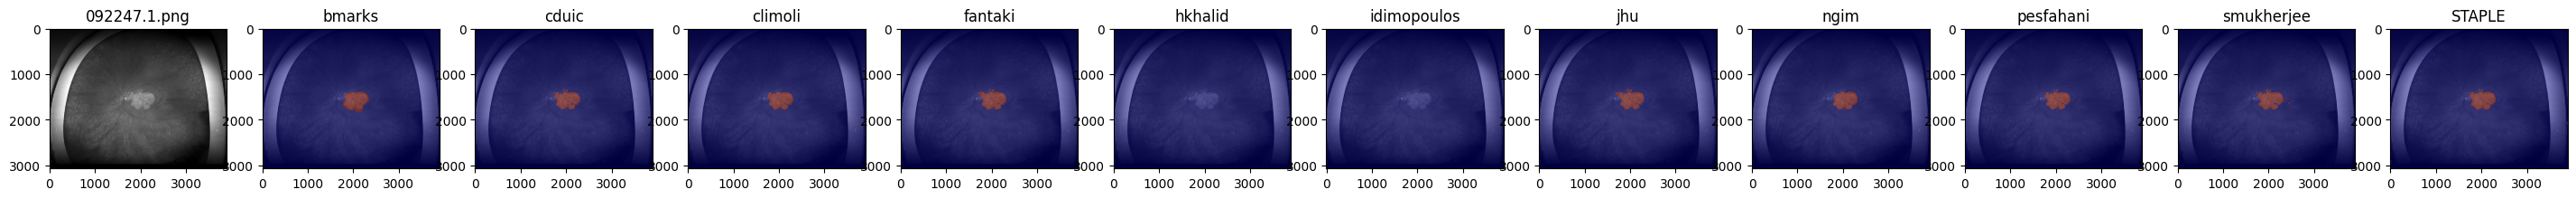

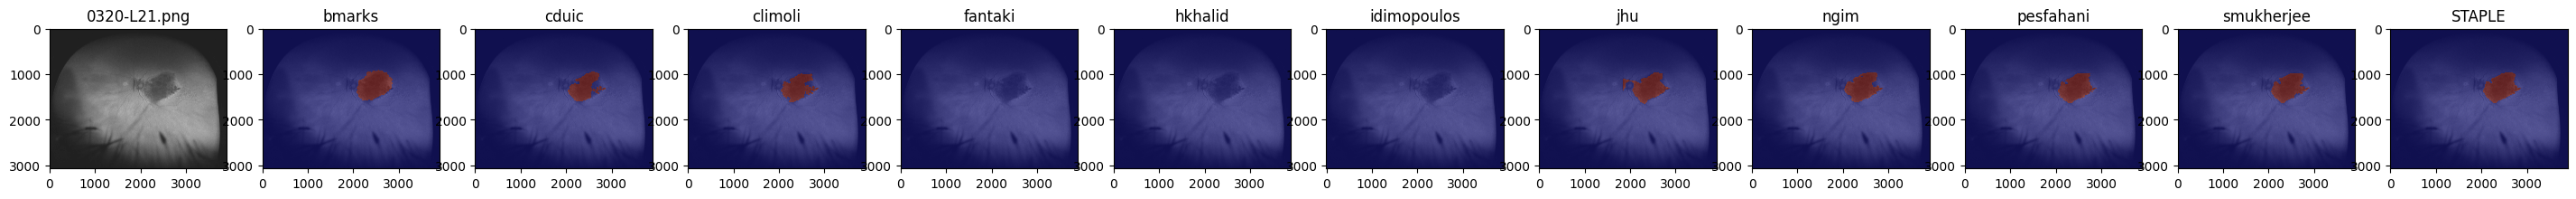

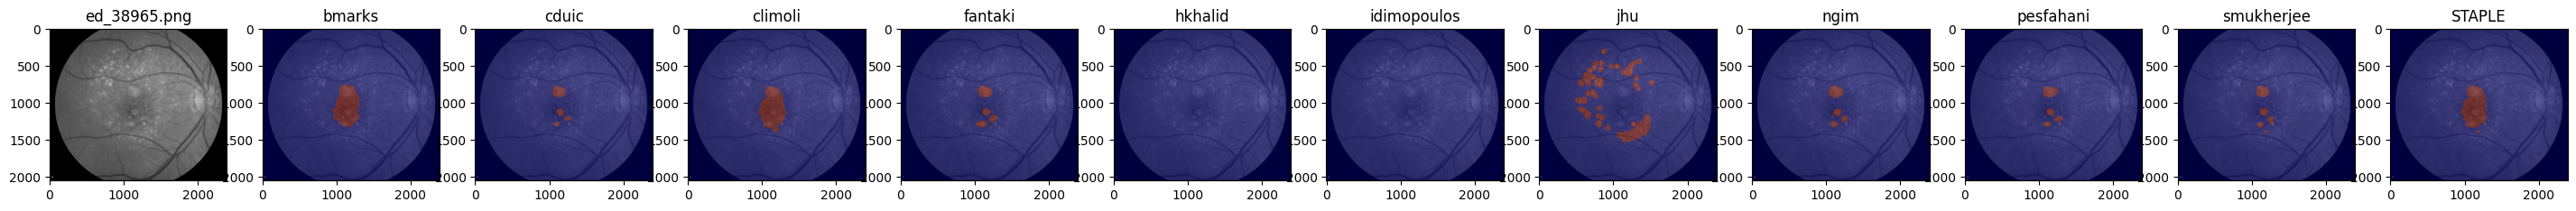

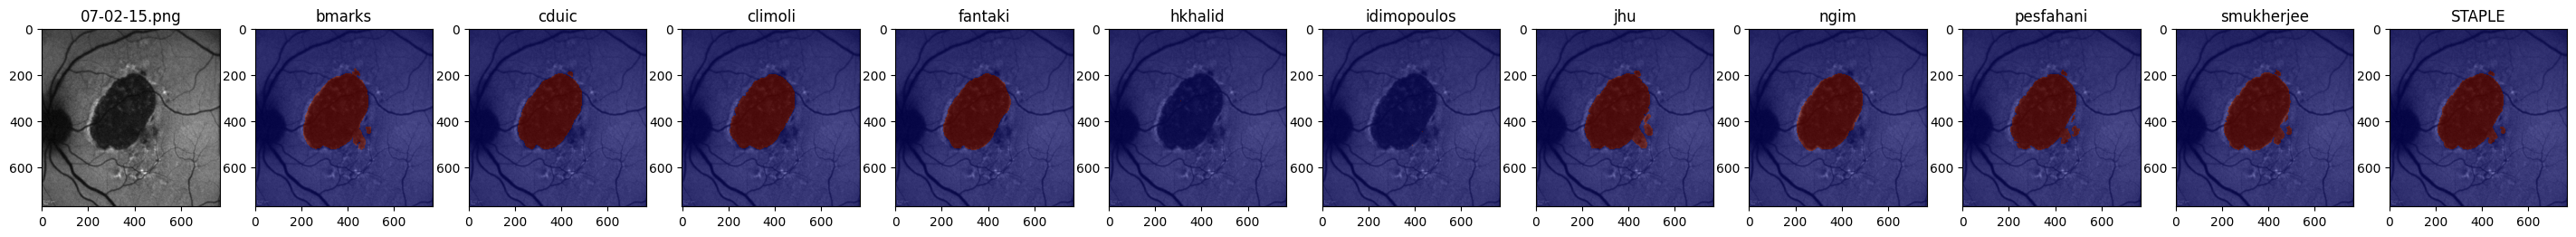

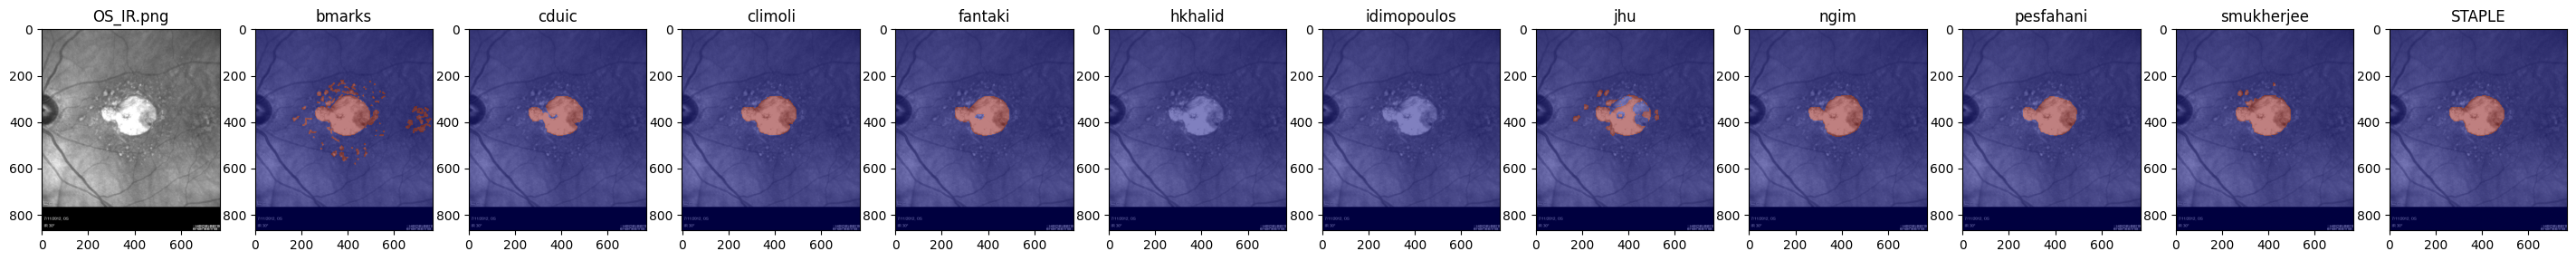

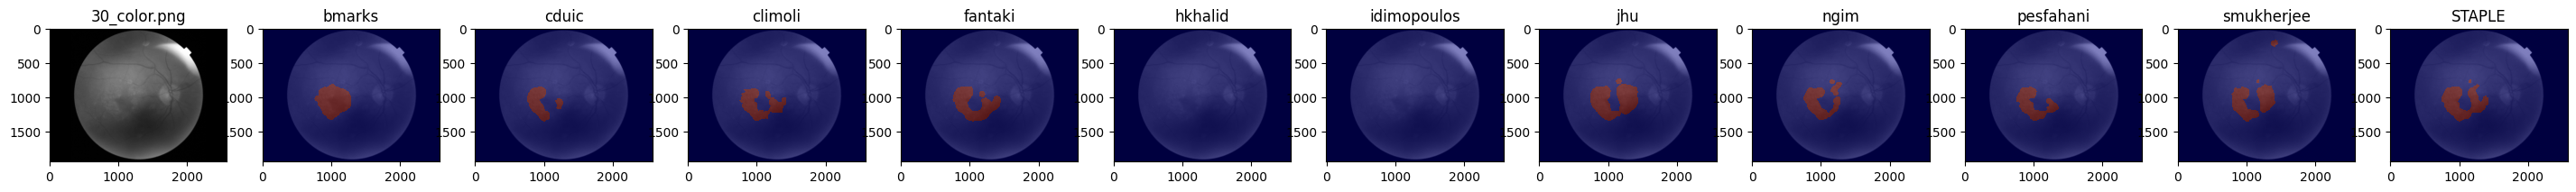

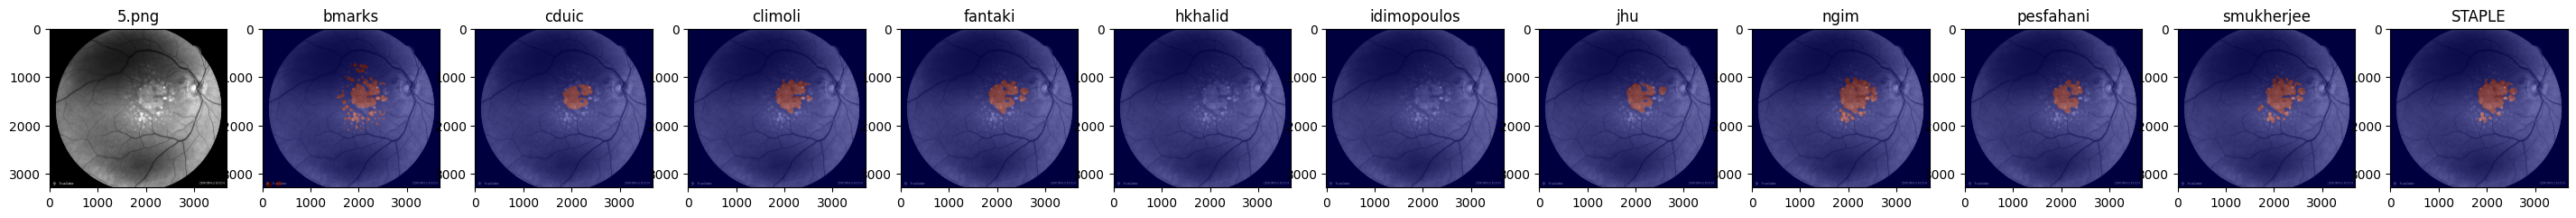

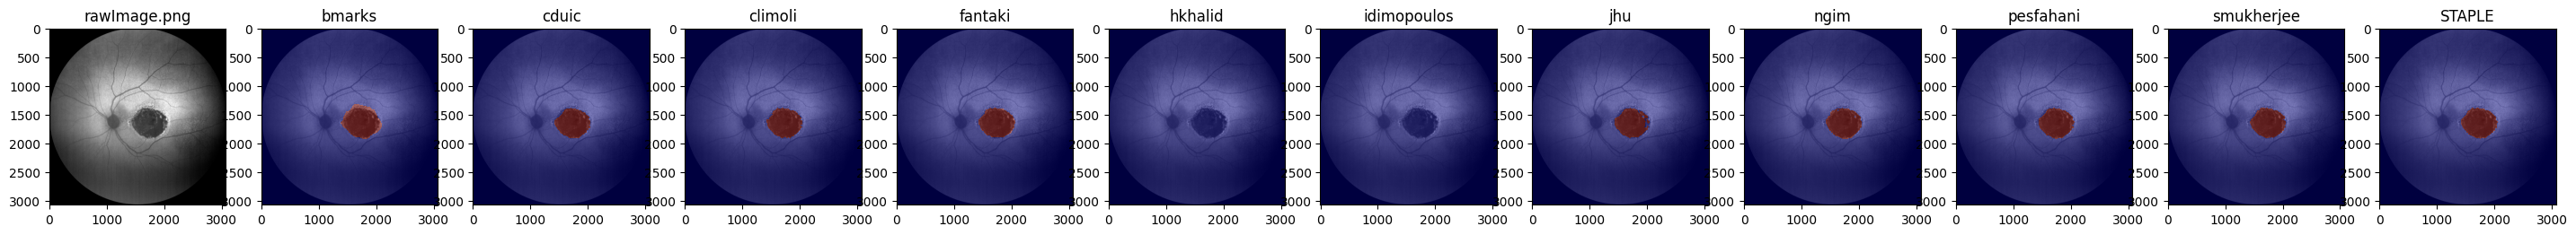

In [14]:

for index, image_generic in enumerate(image_key.keys()):
    generate_all_image_views(image_generic=image_generic, index=index)

In [1]:
# get the error of each rater
for i in range(len(fin_tasks)):
    segs['img_0'][i]['error'] = np.zeros_like(STAPLE_seg_binary)
    segs['img_0'][i]['error'][np.where(STAPLE_seg_binary != segs['img_0'][i]['np_binary'])] = 1


# plot
fig, axes = plt.subplots(1, 2 + len(fin_tasks), figsize=(3*(2+len(fin_tasks)), 3))

axes[0].set_title("Exercise1/...-02-15.png")
axes[0].imshow(np.clip(image, -350, 450), cmap="gray")

for i, axis in enumerate(axes[1:-1]):   
    # display segmentations from our three raters
    axis.set_title(f"Rater {segs['img_0'][i]['user']} Error")
    axis.imshow(np.clip(image, -350, 50), cmap="gray")
    axis.imshow(segs['img_0'][i]['error'], cmap="jet", interpolation="none", alpha=0.8)


axes[-1].set_title("STAPLE")
axes[-1].imshow(np.clip(image, -10, 10), cmap="gray")
axes[-1].imshow(STAPLE_seg_binary, cmap="jet", interpolation="none", alpha=0.8)


# plt.savefig("STAPLE_Error.png")
plt.show()

NameError: name 'fin_tasks' is not defined

In [ ]:
# based on the number of graders that called in 1 for each pixel, we can create a color-coded overlay of the agreement between the graders.

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Count the number of graders that called in 1 for each pixel
grader_counts = segs['img_0'][0]['np_binary'] + \
                segs['img_0'][1]['np_binary'] + \
                segs['img_0'][2]['np_binary'] + \
                segs['img_0'][3]['np_binary'] + \
                segs['img_0'][4]['np_binary'] + \
                segs['img_0'][5]['np_binary'] + \
                segs['img_0'][6]['np_binary'] + \
                segs['img_0'][7]['np_binary'] + \
                segs['img_0'][8]['np_binary'] + \
                segs['img_0'][9]['np_binary']

# Define a custom colormap with a gradient from white to red
cmap_custom = mcolors.LinearSegmentedColormap.from_list(
    "white_to_red", ["#FFFFFF", "#FF0000"]
)

# Plot the STAPLE result with the colored overlay using the custom colormap
plt.imshow(grader_counts, cmap=cmap_custom, interpolation="none")
plt.colorbar(label="Number of Graders Agreeing")
plt.title("Color-Coded Grader Agreement")
plt.show()

# Overlay the STAPLE segmentation mask on top of the image  colormap
# plt.imshow(STAPLE_seg, cmap="jet", interpolation="none", alpha=0.5)  # Use the custom blue colormap for overlay
# plt.show()